In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import cv2

In [2]:
with open('result.pkl', 'rb') as f:
    results = pickle.load(f)

In [3]:
len(results)

6

In [9]:
node_src, node_dst, link_preds, link_labels, preds, label, bbox, node_class_ids, node_class_dict, edge_class_dict, image, img_ids = results[1]
node_class_names = list(node_class_dict.keys())
edge_class_names = list(edge_class_dict.keys())

2


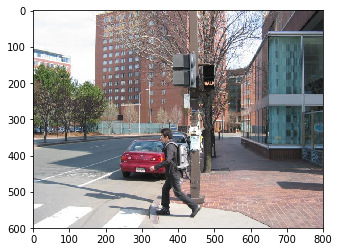

In [10]:
import mxnet as mx
import gluoncv as gcv
from gluoncv import model_zoo, data, utils

img_id = int(img_ids[0])
print(img_id)
img = mx.image.imread('/home/ubuntu/data/visualgenome/VG_100K/%d.jpg'%(img_id))

plt.imshow(img.asnumpy())
plt.show()

In [11]:
def np_softmax(x, axis=-1):
    e_x = np.exp(x - np.expand_dims(np.max(x, axis=axis), 1))
    e_x_sum = np.expand_dims(e_x.sum(axis=axis), 1)
    return e_x / e_x_sum

link_preds_sm = np_softmax(link_preds, 1)
preds_sm = np_softmax(preds, 1)

In [12]:
non_null_label_ind = np.where(label != 0)[0]
non_null_label_ind

array([ 6,  7,  8,  9, 10, 12, 13, 14, 15, 21, 22, 23, 24, 25, 69, 76])

Probability of having the link is 0.625266

predicted <tree, along, road> with probability 0.405359
predicted <tree, be, road> with probability 0.190536
predicted <tree, next, road> with probability 0.141919
predicted <tree, by, road> with probability 0.115854
predicted <tree, behind, road> with probability 0.045394

true relationship is <tree, along, road>


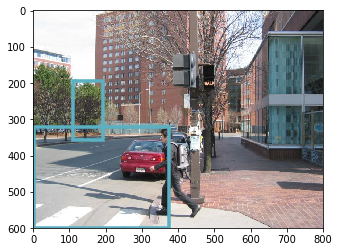

In [16]:
# node_src, node_dst, link_preds, link_labels, preds, label, bbox, class_names
i = non_null_label_ind[8]
bbox_ind = [node_src[i], node_dst[i]]

print('Probability of having the link is %f\n'%(link_preds_sm[i,1]))

sub = node_class_names[int(node_class_ids[node_src[i]])]
ob = node_class_names[int(node_class_ids[node_dst[i]])]
inds = preds[i].argsort()[::-1][0:5]
for k in inds:
    rel = edge_class_names[k]
    print('predicted <%s, %s, %s> with probability %f'%(sub, rel, ob, preds_sm[i][k]))

rel_true = edge_class_names[int(label[i])]
print('\ntrue relationship is <%s, %s, %s>'%(sub, rel_true, ob))

ax = utils.viz.plot_bbox(img, mx.nd.array(bbox[bbox_ind,:]), absolute_coordinates=False)
plt.show()

In [1]:
def _build_complete_graph(bbox, scores, img, thr=0.5):
    bbox_list = []
    bbox_np_list = []
    for i in range(bbox.shape[0]):
        if scores[i] > thr:
            bbox_list.append(bbox[i])
            bbox_np_list.append(bbox[i].asnumpy())

    N = len(bbox_list)
    bbox = mx.nd.stack(*bbox_list)
    g = dgl.DGLGraph()
    g.add_nodes(N)
    edge_list = []
    for i in range(N-1):
        for j in range(i+1, N):
            edge_list.append((i, j))
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    g.add_edges(dst, src)

    img_list = crop_resize_normalize(img, bbox_np_list, (224, 224))
    node_imgs = mx.nd.stack(*img_list)

    img_shape = x.shape
    bbox[:,0] /= img_shape[1]
    bbox[:,1] /= img_shape[0]
    bbox[:,2] /= img_shape[1]
    bbox[:,3] /= img_shape[0]
    g.ndata['bbox'] = bbox
    g.ndata['images'] = node_imgs
    return g

In [ ]:
g = _buil